In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
train_df = pd.read_csv("mnist_train.csv")
test_df  = pd.read_csv("mnist_test.csv")

print(train_df.shape, test_df.shape)
train_df.head()

(60000, 785) (10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
class MNISTDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:, 0].values.astype(np.int64)
        self.images = df.iloc[:, 1:].values.astype(np.float32)
        self.images = self.images.reshape(-1, 1, 28, 28) / 255.0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])
        y = torch.tensor(self.labels[idx])
        return x, y

In [4]:
dataset = MNISTDataset(train_df)
train_size = int(0.9 * len(dataset))
val_size   = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
epochs = 8
train_losses = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/8 | Train Loss: 0.2472 | Val Loss: 0.0567 | Val Acc: 0.9828
Epoch 2/8 | Train Loss: 0.0753 | Val Loss: 0.0410 | Val Acc: 0.9862
Epoch 3/8 | Train Loss: 0.0572 | Val Loss: 0.0400 | Val Acc: 0.9878
Epoch 4/8 | Train Loss: 0.0454 | Val Loss: 0.0422 | Val Acc: 0.9872
Epoch 5/8 | Train Loss: 0.0374 | Val Loss: 0.0372 | Val Acc: 0.9872
Epoch 6/8 | Train Loss: 0.0320 | Val Loss: 0.0381 | Val Acc: 0.9900
Epoch 7/8 | Train Loss: 0.0273 | Val Loss: 0.0346 | Val Acc: 0.9908
Epoch 8/8 | Train Loss: 0.0230 | Val Loss: 0.0330 | Val Acc: 0.9903


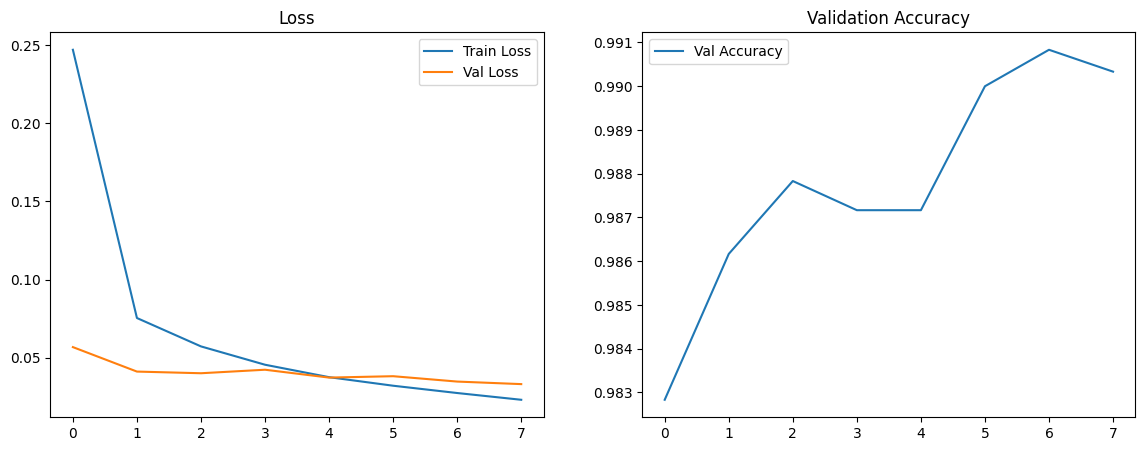

In [8]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")

plt.show()

In [9]:
class TestMNIST(Dataset):
    def __init__(self, df):
        # retire la 1ère colonne (colonne parasite)
        images = df.iloc[:, 1:].values.astype(np.float32)

        # reshape en 1×28×28
        images = images.reshape(-1, 1, 28, 28) / 255.0
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx])
test_set = TestMNIST(test_df)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [10]:
model.eval()
predictions = []

with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [11]:
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(predictions)+1),
    "Label": predictions
})

submission.to_csv("submission.csv", index=False)
submission.head()

,ImageId,Label
0,1,7
1,2,2
2,3,1
3,4,0
4,5,4
